In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from resources.tokTT import CommentTokenizer as CT
from resources.basicIO import InputOutput as IO
from resources.filterLang import FilterLanguage as FL
from resources.expansion import Expand_U
from resources.fasttext_transformer import classify
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fasttext
from scipy import spatial
from sklearn import svm
#from sklearn.linear_model import LassoLars
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay


[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [3]:
model_2 = fasttext.load_model("models/ft_unsupervised_N_2.bin")
model_3 = fasttext.load_model("models/ft_unsupervised_N_3.bin")


In [26]:
df_sample = pd.read_csv("datasets/random_sample_data.csv")
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample['label'].value_counts()


0    1846
1    1408
Name: label, dtype: int64

In [27]:
X_raw = df_sample['tokenized_comment']
y = df_sample['label']

X_2 = [model_2[x] for x in X_raw]
X_3 = [model_3[x] for x in X_raw]


In [28]:
# modify here to change models
X = X_3
model = model_3
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.1,
                                                    random_state=25,
                                                    stratify=y)
print(len(X_train))
print(len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())

2928
326
0    1661
1    1267
Name: label, dtype: int64
0    185
1    141
Name: label, dtype: int64


In [29]:
N_SAMPLES = 1000

classifiers = {
    "SVM": make_pipeline(StandardScaler(), svm.SVC(probability=True, kernel='rbf')),
    "KNN": KNeighborsClassifier(n_neighbors=20),
    "LR": make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', penalty='l2', C=0.05, max_iter=10000, random_state=2))
}


In [30]:
X_seed, X_expand, y_seed, y_expand = train_test_split(X_train,
                                                      y_train, test_size=0.99,
                                                      random_state=41,
                                                      stratify=y_train)


### Compare uncertain selection criterias

In [47]:
best_select = [1,2,5,10]
X_u = []
y_u = []

for i in best_select:


    X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                    classifiers["LR"],
                                                                                    list(
                                                                                        X_seed),
                                                                                    list(
                                                                                        y_seed),
                                                                                    list(
                                                                                        X_expand),
                                                                                    list(
                                                                                        y_expand),
                                                                                    20,
                                                                                    i
                                                                                    )
    X_u.append(X_uncertain_exp_u)
    y_u.append(y_uncertain_exp_u)

In [48]:
len(X_expand)

2899

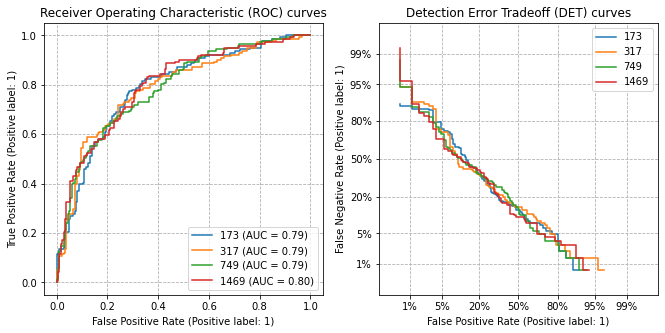

In [51]:
# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
clf = classifiers["LR"]

for i in range(len(X_u)):
    clf.fit(X_u[i], y_u[i])

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=str(len(X_u[i])))
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=str(len(X_u[i])))

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig('outputs/figures/' + 'ROC_DET_LR_u_LR_N3',dpi=300, bbox_inches='tight')
plt.show()
